In [ ]:
!git clone https://github.com/desmond-ong/pplAffComp.git
%cd pplAffComp/code
!pip install torch torchvision pyro-ppl

fatal: destination path 'pplAffComp' already exists and is not an empty directory.
/content/pplAffComp/code


In [ ]:
import os
import urllib # for urllib.urlretrieve()

import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from torchvision import transforms, utils, datasets
from PIL import Image
import helperCode

print("Currently using Pyro version: " + pyro.__version__)

IMG_WIDTH = 100
IMG_SIZE = IMG_WIDTH*IMG_WIDTH*3
BATCH_SIZE = 10
DEFAULT_HIDDEN_DIMS = 400
DEFAULT_Z_DIM = 50

Currently using Pyro version: 0.4.0


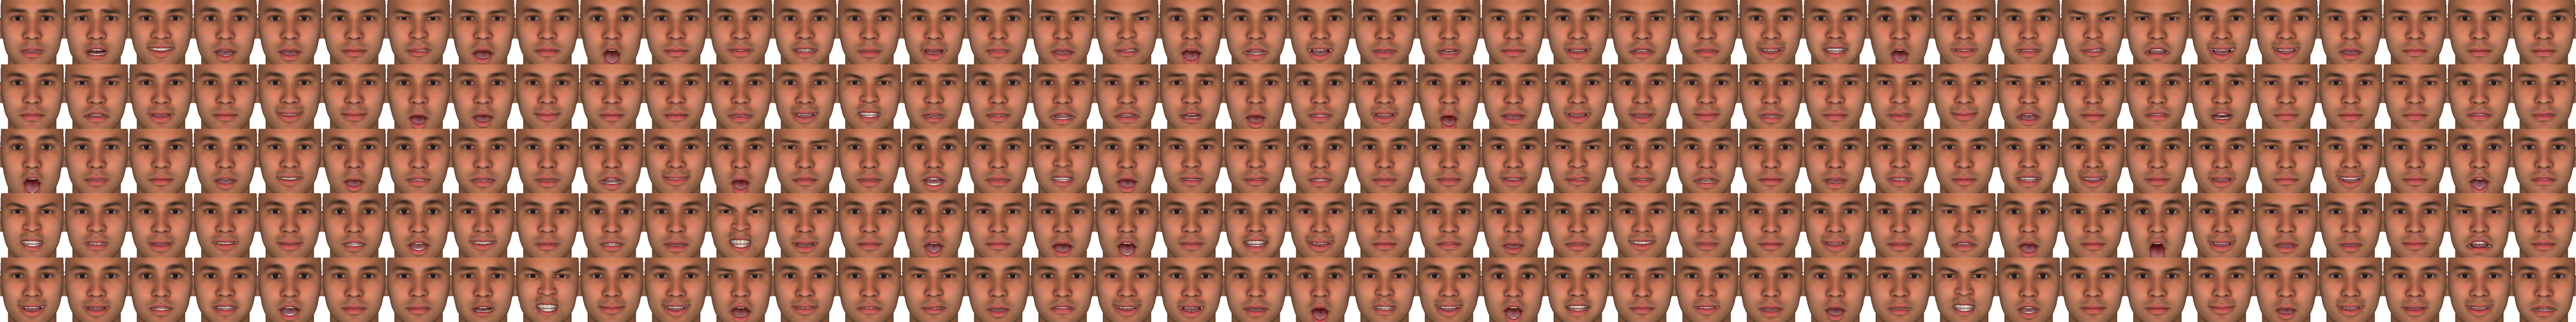

In [ ]:
more_faces_path = os.path.join(os.path.abspath('..'), "CognitionData", "more_faces")
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
more_faces_dataset = datasets.ImageFolder(root=more_faces_path, transform=data_transform)
more_faces_loader = torch.utils.data.DataLoader(more_faces_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4)


# initializing temp arrays
faceArray1 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray2 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray3 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray4 = np.zeros(shape=(100,1,3), dtype='uint8')
faceArray5 = np.zeros(shape=(100,1,3), dtype='uint8')

count = 0
for faceFilename in os.listdir(os.path.join(more_faces_path, 'img')):
  newFaceArray = np.array(Image.open(os.path.join(more_faces_path, 'img', faceFilename)))
  if count < 40:
    faceArray1 = np.concatenate((faceArray1, newFaceArray), axis=1)
  elif count < 80:
    faceArray2 = np.concatenate((faceArray2, newFaceArray), axis=1)
  elif count < 120:
    faceArray3 = np.concatenate((faceArray3, newFaceArray), axis=1)
  elif count < 160:
    faceArray4 = np.concatenate((faceArray4, newFaceArray), axis=1)
  elif count < 200:
    faceArray5 = np.concatenate((faceArray5, newFaceArray), axis=1)
  count += 1

# concatenating the arrays and removing the first temp column
faceArray = np.concatenate((faceArray1, faceArray2, faceArray3, faceArray4, faceArray5), axis=0)
faceArray = faceArray[:,1:,:]
Image.fromarray(faceArray)

In [ ]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(IMG_SIZE, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, IMG_SIZE)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, IMG_SIZE)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


## Model

In [ ]:
# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("observed_data"):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, IMG_SIZE))
            # return the loc so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("observed_data"):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img


In [ ]:
class Args:
    learning_rate = 5e-5
    num_epochs = 2 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    seed = 10
    cuda = False

args = Args()

# setup the VAE
vae = VAE(z_dim=args.z_dim, hidden_dim=args.hidden_layers, use_cuda=args.cuda)

# setup the optimizer
adam_args = {"lr": args.learning_rate}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

### Training loop

This next chunk of code runs the training over `num_epochs` epochs.

In [ ]:
train_elbo = []
# training loop
for epoch in range(args.num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for batch_num, (x, _) in enumerate(more_faces_loader):
        # if on GPU put mini-batch into CUDA memory
        if args.cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        #print("Batch: ", batch_num, "out of", len(train_loader))
        epoch_loss += svi.step(x)

    # report training diagnostics
    normalizer_train = len(more_faces_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    train_elbo.append(total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 20777.0300
[epoch 001]  average training loss: 19601.0398


In [ ]:
# save model if you decide to modify the above code to train your own model
savemodel = False
if savemodel:
    if not os.path.exists('trained_models'):
      os.mkdir('trained_models')
    pyro.get_param_store().save('trained_models/vae_pretrained.save')

In [ ]:
## making a "trained_models" directory
if not os.path.exists('trained_models'):
    os.mkdir('trained_models')

## use this chunk to download a saved version of the model directly onto colab
downloadmodel = True
if downloadmodel:
    urllib.request.urlretrieve(
        "https://www.dropbox.com/s/eknoyrig6wjkp08/vae_pretrained.save?dl=1",
        "trained_models/vae_pretrained.save")
    print("Model downloaded")

## use this chunk to help upload the file if you have it on your local machine
#from google.colab import files
#!mkdir trained_models
#%cd trained_models
#files.upload()
#%cd ..

Model downloaded


In [ ]:
loadmodel = True
if loadmodel:
    pyro.get_param_store().load('trained_models/vae_pretrained.save')
    pyro.module("decoder", vae.decoder, update_module_params=True)
    pyro.module("encoder", vae.encoder, update_module_params=True)

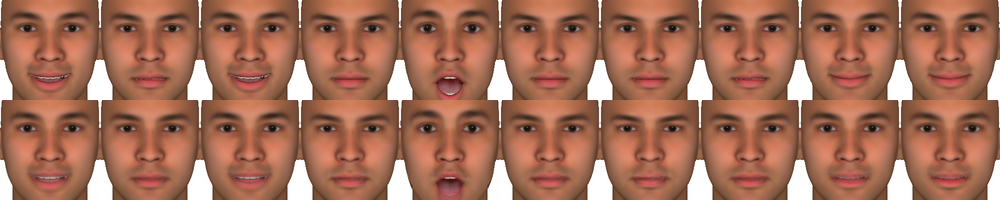

In [ ]:
NUM_SAMPLES = 10
input_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")
reconstructed_array = np.zeros(shape=(IMG_WIDTH, 1, 3), dtype="uint8")

for i, (x, _) in enumerate(more_faces_loader):
    # pick NUM_SAMPLES random test images from the first mini-batch and
    # visualize how well we're reconstructing them
    if i == 0:
        reco_indices = np.random.randint(0, x.size(0), NUM_SAMPLES)
        for index in reco_indices:
            input_img = x[index, :]
            # storing the input image
            input_img_display = np.array(input_img*255., dtype='uint8')
            input_img_display = input_img_display.transpose((1, 2, 0))
            input_array = np.concatenate((input_array, input_img_display), axis=1)

            # generating the reconstructed image and adding to array
            reconstructed_img = vae.reconstruct_img(input_img)
            reconstructed_img = reconstructed_img.view(3, IMG_WIDTH, IMG_WIDTH).detach().numpy()
            reconstructed_img = np.array(reconstructed_img*255., dtype='uint8')
            reconstructed_img = reconstructed_img.transpose((1, 2, 0))
            reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)

# remove first, blank column, and concatenate
input_array = input_array[:,1:,:]
reconstructed_array = reconstructed_array[:,1:,:]
display_array = np.concatenate((input_array, reconstructed_array), axis=0)
Image.fromarray(display_array)